In [1]:
cd "./einstein/"

/Users/xuejiaxin/Dropbox/My Mac (Jiaxin的MacBook Pro)/Documents/GitHub/latent/pytorch-pretrained-BigGAN/einstein


In [2]:
from PIL import Image
from torchvision import transforms

img = Image.open("./img02.jpg")
output = transforms.ToTensor()(img).unsqueeze_(0)

In [3]:
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
import logging


logging.basicConfig(level=logging.INFO)

model = BigGAN.from_pretrained('biggan-deep-128')

INFO:pytorch_pretrained_biggan.model:loading model biggan-deep-128 from cache at /Users/xuejiaxin/.pytorch_pretrained_biggan/6371c3777477e4e75187da1b9b526561aac3134f38c7299a3438009ae560e20d.3434ebdfa74a8c17e0e56061cfd905fa163c92f110e88df77b47da6ce9910b48
INFO:pytorch_pretrained_biggan.model:Model config {
  "attention_layer_position": 8,
  "channel_width": 128,
  "class_embed_dim": 128,
  "eps": 0.0001,
  "layers": [
    [
      false,
      16,
      16
    ],
    [
      true,
      16,
      16
    ],
    [
      false,
      16,
      16
    ],
    [
      true,
      16,
      8
    ],
    [
      false,
      8,
      8
    ],
    [
      true,
      8,
      4
    ],
    [
      false,
      4,
      4
    ],
    [
      true,
      4,
      2
    ],
    [
      false,
      2,
      2
    ],
    [
      true,
      2,
      1
    ]
  ],
  "n_stats": 51,
  "num_classes": 1000,
  "output_dim": 128,
  "z_dim": 128
}



In [18]:
from torchvision.models import squeezenet1_0
from tqdm import trange
from torch import nn

DEVICE = 'cpu'
model = model.eval().to(DEVICE)


semantic_model = squeezenet1_0(pretrained=True).to(DEVICE)
semantic_model.classifier = torch.nn.Sequential(
    torch.nn.Flatten()
    )
semantic_model = semantic_model.eval()

soft_max = nn.Softmax(dim = 1)
cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)

truncation = 0.5
noise = truncated_noise_sample(truncation=truncation, batch_size=1, seed=1)
noise = torch.nn.Parameter(torch.tensor(noise, requires_grad=True).float().to(DEVICE))

class_vector = one_hot_from_names(['macaque'], batch_size=1)  #macaque
class_vector = torch.from_numpy(class_vector)
#class_vector = torch.nn.Parameter(torch.tensor(class_vector, requires_grad=True).float().to(DEVICE))

optim = torch.optim.Adam([noise, class_vector], lr=0.05)

save_as_images(model(noise, class_vector, truncation), f"start")

L = []
L_pixel = []
L_semantic = []

for iteration in trange(0, 201):
    optim.zero_grad()

    
    #class_vector_1 = torch.zeros_like(output_1)
    #class_vector_1[0][output_1.argmax(1)] = 1.0

    #output_1 = soft_max(class_vector)

    y_hat = model(noise, class_vector, truncation)

    #semantic_loss = -((semantic_model(y_hat) - semantic_model(output)) ** 2).mean() ** .5 
    semantic_loss = -cos_sim(semantic_model(y_hat), semantic_model(output))
    L_semantic.append(semantic_loss.item())

    pixel_loss = abs(y_hat - output).mean()
    L_pixel.append(pixel_loss.item())

    loss = 100 * semantic_loss + 30 * pixel_loss
    L.append(loss.item())

    loss.backward()
    optim.step()


    if iteration % 1 == 0:
        save_as_images(y_hat, f"monkey2einstein_{iteration}")

INFO:pytorch_pretrained_biggan.utils:Saving image to start_0.png
100%|██████████| 201/201 [10:17<00:00,  3.07s/it]


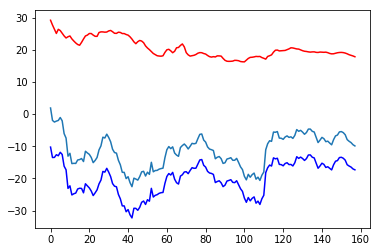

In [17]:
import matplotlib.pyplot as plt


plt.plot(L)
plt.plot([x*60 for x in L_pixel], 'r')
plt.plot([x*100 for x in L_semantic], 'b')

plt.show()